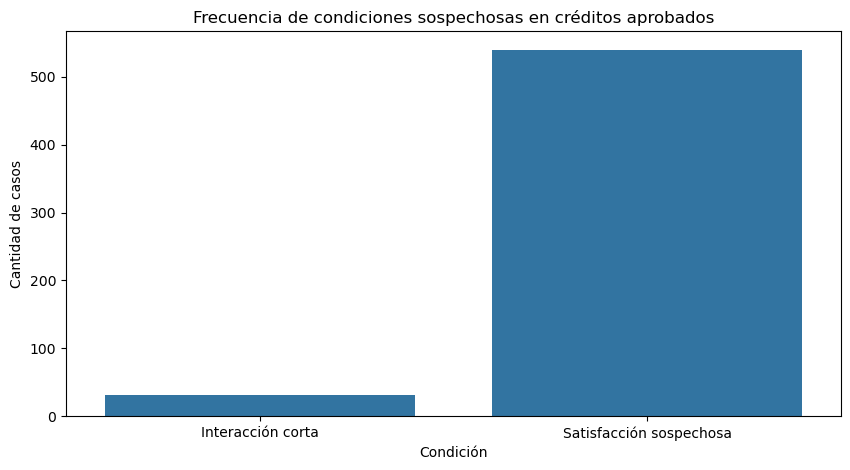

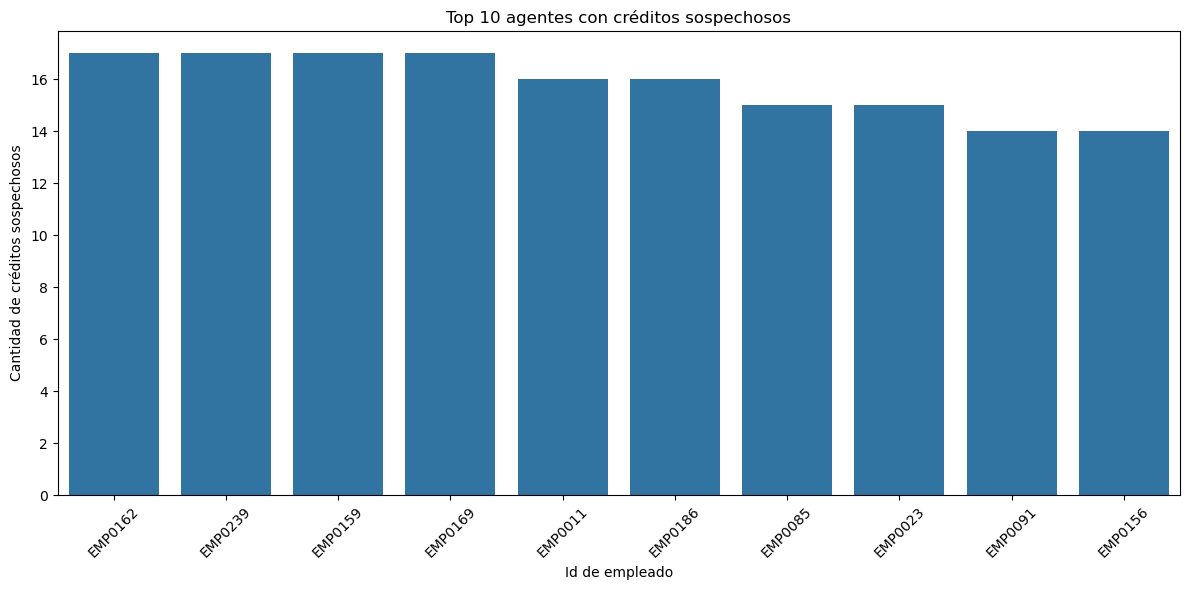

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivos desde ruta local
df_creditos = pd.read_excel(r"\Creditos.xlsx")
df_satisfaccion = pd.read_excel(r"\Encuesta_satisfaccion.xlsx")
df_interacciones = pd.read_excel(r"\Interacciones.xlsx")

# Asegurar formatos de fecha
df_creditos['Fecha y hora de interacción'] = pd.to_datetime(df_creditos['Fecha y hora de interacción'])
df_satisfaccion['Fecha y hora'] = pd.to_datetime(df_satisfaccion['Fecha y hora'])
df_interacciones['Fecha y hora de interacción'] = pd.to_datetime(df_interacciones['Fecha y hora de interacción'])

# Unir créditos con duración de interacción
df_merged = pd.merge(
    df_creditos,
    df_interacciones[['Id del caso', 'Duración']],
    on='Id del caso',
    how='left'
)

# Unir con satisfacción
df_final = pd.merge(
    df_merged,
    df_satisfaccion[['Id del caso', 'Satisfacción']],
    on='Id del caso',
    how='left'
)

# Crear variables para condiciones sospechosas
df_final['Hora'] = df_final['Fecha y hora de interacción'].dt.hour
df_final['Turno'] = df_final['Hora'].apply(lambda x: 'Fuera de turno' if x < 7 or x >= 20 else 'En turno')
df_final['Interacción corta'] = df_final['Duración'] < 300  # Menos de 5 minutos
df_final['Satisfacción sospechosa'] = df_final['Satisfacción'] >= 9

# Marcar registros sospechosos
df_final['Sospechoso'] = df_final[['Interacción corta', 'Satisfacción sospechosa']].any(axis=1) | (df_final['Turno'] == 'Fuera de turno')

# Filtrar sospechosos
sospechosos = df_final[df_final['Sospechoso'] == True]

# ---------- GRÁFICO 1: Tipo de sospecha ----------
plt.figure(figsize=(10, 5))
sospechosos_melt = sospechosos.melt(id_vars='Id de empleado', value_vars=['Interacción corta', 'Satisfacción sospechosa', 'Turno'])
sospechosos_melt = sospechosos_melt[sospechosos_melt['value'] == True]
sns.countplot(data=sospechosos_melt, x='variable')
plt.title('Frecuencia de condiciones sospechosas en créditos aprobados')
plt.xlabel('Condición')
plt.ylabel('Cantidad de casos')
plt.show()

# ---------- GRÁFICO 2: Top 10 agentes con créditos sospechosos ----------
plt.figure(figsize=(12, 6))
top_empleados = sospechosos['Id de empleado'].value_counts().head(10)
sns.barplot(x=top_empleados.index, y=top_empleados.values)
plt.title('Top 10 agentes con créditos sospechosos')
plt.xlabel('Id de empleado')
plt.ylabel('Cantidad de créditos sospechosos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
